#### Install Pre-requisite Python Modules

In [ ]:
%pip install -r requirements.txt

### List Available Modules
Run the Cell below to list the names of the available:
- Perceptual Hashing Algorithms
- Transformers
- Similarity Metrics

In [ ]:
from notebooksupport import list_modular_components

nl = '\n'
for module_name, functions in list_modular_components().items():
    print( f"{module_name}:{nl}{nl.join(functions)}")
    print(nl)

### Test Transforms
- Test out transforms and their parameters.

c:\Users\Sean\Documents\GitHub\test_lib\test\Border_bw30_bc255.0.0\972381743_5677b420ab.jpg


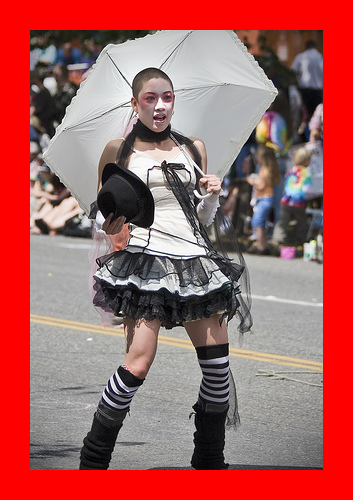

c:\Users\Sean\Documents\GitHub\test_lib\test\Crop_fixed[20, 20, 0, 0]\972381743_5677b420ab.jpg


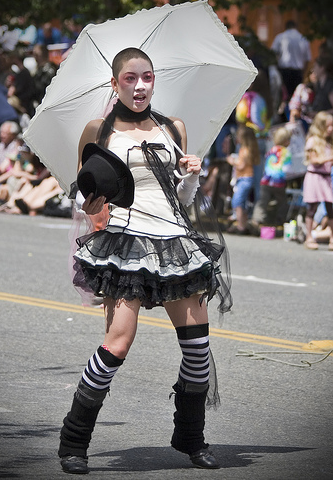

AttributeError: module 'PIL.ImageEnhance' has no attribute 'color'

In [1]:
from phaser.transformers import *
from phaser.utils import ImageLoader

# list of functions and parameters to create transform classes
# Edit these to change output.
transforms = [
    Border(border_colour=(255,0,0), border_width=30),
    Crop(cropbox_absolute=[20,20,0,0]),
    Enhance(sharpnessfactor=0.0, contrastfactor=2, colourfactor=0.3, brightnessfactor=0.7),
    Flip(direction='Horizontal'),
    Rescale(scalefactor=2.1, thumbnail_aspect=False),
    Rescale(fixed_dimensions=(200,200), thumbnail_aspect=True),
    Rotate(degrees_counter_clockwise=10),
    Rotate(degrees_counter_clockwise=-20),
    Watermark()
]

# Load an image to transform
im = ImageLoader(f"images/972381743_5677b420ab.jpg")

# Apply each specified transform to the image and save to "test/"
for t in transforms:
    modified = t.fit(im) # fit function applies the transform
    filepath = t.saveToDisk(image=modified, save_directory="test", filename=im.filename )
    print(filepath)
    display(modified)

#### Set Experimental Conditions
- Specify path to original (unmodified) images. Transforms will be applied to these, and these serve as the ground truth for intra-distance analysis.
- Specify output directory
- Specify dictionary of Perceptual Hashes to use (with parameters)
    - Format: ```<name_string>: <class_name>(<arguments>)```
    - Must be imported in this cell, base algorithms defined in ```phaser.hashing._algorithms.py```.
    - Class should extend ```phaser.hashing._algorithms.PerceptalHash```
- Specify Transforms to use.
    - Format: ```<clas_name>(<arguments>)```
    - Must be imported in this cell, base algorithms defined in ```phaser.transformers._transforms.py```.
    - Use ```TransformFromDisk``` and specify a path as the argument if the transform files already exist on disk (must have same name as originals to match)
- Specify Distance metrics to use.
    - Format: Dictionary with ```<Human Readable Name>:<metric>``` (metric should be str or Callable, see below)
    - If the distance metric is part of ```scipy.spatial.distance```, specify the name as a ```str```
    - If a custom distance metric is provided in ```phaser.similarities._distances.py```, import and pass the ```function reference```

In [ ]:
# Specify path of the original (non-transformed) dataset
# e.g. "F:\Datasets\images"
original_path = r"images"

# Specify output directory
output_directory = r"./demo_outputs"

# Specify Perceptual Hashing Algorithms

from phaser.hashing import *
ALGORITHMS = {
        'pHash': PHash(hash_size=8, highfreq_factor=4),
        'Colourhash': ColourHash()
        }

# Specify Transforms functions 
from phaser.transformers import *
TRANSFORMERS = [
    # Border(border_color=(255,0,0), border_width=30, saveToPath=''),
    Flip(direction='Horizontal'),
    Border(border_colour=(255,0,0), border_width=30, saveToDir='test/'),
    Watermark(),
    # TransformFromDisk(r"F:/testmods/Border30black"),
    # TransformFromDisk(r"F:/testmods/Crop5pc"),
    # TransformFromDisk(r"F:/testmods/Mirrorx"),
    # TransformFromDisk(r"F:/testmods/Watermark/")

    ]

from phaser.similarities import *
DISTANCE_METRICS = {
    "Hamming": "hamming"#,
    # "Cosine": "cosine",
    # "Test_Synthetic": test_synthetic
}

# === EDIT ABOVE LINE ======================

# Test that metrics have been entered correctly
from phaser.similarities import validate_metrics
if validate_metrics(DISTANCE_METRICS):
    print("Metrics look valid!")

#### Process Files

- Hash original files with each algorithm
- Generate and hash transform files
- Output hashes to CSV files compressed to .bz (bzip) files

In [ ]:
from notebooksupport import do_hashing

# Pass the settings through to a helper function which does the hashing and applies transforms
do_hashing(originals_path=original_path, algorithms=ALGORITHMS, transformers=TRANSFORMERS, output_directory=output_directory, n_jobs=-1, progress_report=True)

#### Calculate Similarity Scores
There are two types of score calculated here:
- Intra-score: Where the original images are compared to their modifications. This is a 1-to-1 mapping (N * #hashes * #transforms * #comparison_metrics)
    - This is used to determine how robust the hash and comparison metric are to each transform class.
    - Ideally original images should have a distance of 0 (simlartiy of 1) to their transforms.
- Inter-score: Where images within a given tranform (or originals) are compared to themselves for each given comparison metric. Inter-scores are sampled to match the size of the intra-score class. (Calculating all pairwise combinations generates many more samples, (N*N-1/2)
    - This gives us a baseline behaviour, with the assumption that the images should *not* match.
    - On aggregate, random unrelated images should be about 0.5 different, as this makes the best use of the metric space.



In [ ]:
from notebooksupport import calculate_distances

# Load hashes and labels from the output generated by the previous step and calculate inter- and intra-distances.
calculate_distances(hash_directory=output_directory, distance_metrics=DISTANCE_METRICS, progress_report=True)